In [29]:
import numpy as np
import pandas as pd
import pickle
import smogn
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

### Objective

We saw in notebook 3 that a linear regression was not a viable model. In this notebook we will talk about a solution to working with our dataset. 

1. We will discuss SMOGN (Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise), which is a pre-processing method for dealing with small data with imbalanced domains (where we have a few games with very high number of uc_posts which are of high interest)
2. We will then create various models on our small dataset and compare the performance on the original dataset vs.  the SMOGN-applied dataset.

### SMOGN (Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise)

SMOGN is a pre-processing strategy used when there is domain imbalance (the values of interest for predicting are rare or uncommon) in data and the target variable is continuous.

In our case, there is domain imbalance strictly because there are not many FPS games in our dataset and because of them, there are just a few games which have a very high $y$ value. We want to use SMOGN because we want to be able to predict when a game will have those very high instances of cheating.

As an overview, SMOGN applies random under-sampling for normal cases of $y$ and two types of over-sampling for rare cases of $y$. The two over-sampling methods are called SMOTER and Gaussian noise. 

SMOTER is a strategy used to create new data through interpolation (interpolation is creating a new data point inside the range of existing datapoints). First, a rare case (of $y$) is selected as a seed and another rare case is randomly selected from the K-nearest neighbors of the seed. A new datapoint is created as a weighted average of the target variable values of the two rare cases used. Gaussian noise is creating datapoints by adding noise to existing datapoints, where the noise has a normal distribution.

For over-sampling on rare cases, SMOGN uses SMOTER when the seed and its K-nearest neighbor are close enough. When they are not close enough, it creates a new datapoint by adding Gaussian noise to the rare seed. This means the boundaries for the rare cases are expanded less conservatively when the seed and K-nearest neighbor are within a close distance, but otherwise expanded conservatively. It applies this algorithm to all rare seeds in the data.

sources: 
* http://proceedings.mlr.press/v74/branco17a/branco17a.pdf
* https://github.com/nickkunz/smogn
* https://en.wikipedia.org/wiki/Gaussian_noise

First, we will apply SMOGN to our data and create a linear regression model. We will compare the linear regression from 3_linear_model notebook to the new one.

### Linear Regression with SMOGN pre-processing

#### Load Data

In [2]:
X_train_preprocessed = pd.read_pickle('../data/X_train_preprocessed')
X_test_preprocessed = pd.read_pickle('../data/X_test_preprocessed')
y_train = pd.read_pickle('../data/y_train')
y_test = pd.read_pickle('../data/y_test')

In [3]:
# SMOGN is performed on the entire dataset, so we will recombine the data before applying the algorithm

In [4]:
# combining data

# join X and y
train_data = X_train_preprocessed.join(y_train, on='game_id').copy()
test_data = X_test_preprocessed.join(y_test, on='game_id').copy()

# drop game_id columns
train_data.drop(columns=['game_id'], inplace=True)
test_data.drop(columns=['game_id'], inplace=True)

# re-combine train and test
all_data = pd.concat([train_data, test_data])
# reset index
all_data.reset_index(drop=True, inplace=True)

In [5]:
# look at shape
all_data.shape

(35, 8831)

#### Install SMOGN 
to install SMOGN please use the following:
```!pip install git+https://github.com/nickkunz/smogn.git```

#### Run SMOGN-preprocessing on data

In [6]:
# perform SMOGN on combined data
# smogn.smoter uses a function which has a performance warning, so the following surpresses it:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# create smogn data
smogn_data = smogn.smoter(data=all_data, y='uc_posts', k=3, replace=True)

synth_matrix: 100%|##########| 9/9 [00:03<00:00,  2.65it/s]


In [28]:
smogn_data.shape

(31, 8831)

SMOGN has many parameters which can be tuned. The two we used are:
* `k` is the number of neighbors considered when over-sampling the random cases
* `replace` determines if under-sampling is performed with replacement.

We see now that the mean of the $y$ is much higher:

In [7]:
smogn_data['uc_posts'].mean(), all_data['uc_posts'].mean()

(70821.07770643898, 36486.26485260771)

We also see that the distribution of $y$ leans more towards its high values:

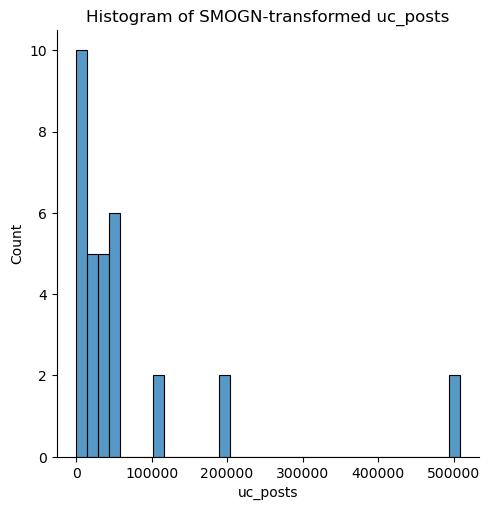

In [8]:
# plot histogram
smogn_data.reset_index(drop=True, inplace=True)
rel = sns.displot(smogn_data, x="uc_posts", bins=35)
rel.set(title='Histogram of SMOGN-transformed uc_posts')
plt.show();

#### Save Data

In [9]:
# you cannot set a random seed with the smogn module, so we save our data output:
smogn_data.to_pickle('../data/smogn_data')

#### Linear Regression
Next, we create a linear regression model to compare to the model from notebook 3:

In [10]:
# define X and y
X_smogn = smogn_data.drop(columns='uc_posts')
y_smogn = smogn_data['uc_posts']

In [15]:
y_smogn.mean()

70821.07770643898

In [11]:
# train-test split
X_train_smogn, X_test_smogn, y_train_smogn, y_test_smogn = train_test_split(X_smogn, y_smogn, test_size=0.2, random_state=10)

In [12]:
y_train_smogn.mean(), y_test_smogn.mean()

(70918.14489314325, 70474.40918249516)

In [13]:
# instantiate linear regression
lr = LinearRegression()
# fit to encoded training data
lr.fit(X_train_smogn, y_train_smogn)

LinearRegression()

#### Model Evaluation

In [14]:
# check r-squared for train and test
lr.score(X_train_smogn, y_train_smogn).round(10), lr.score(X_test_smogn, y_test_smogn).round(3)

(0.9999999997, 0.785)

We see that the model test score is improved considerably. Although the data is still too small to say anything conclusive, SMOGN improved the test score of the linear regression.

In [17]:
# calculate residuals by creating predictions for training set
preds_smogn = lr.predict(X_train_smogn)
resid_smogn_train = y_train_smogn - preds_smogn

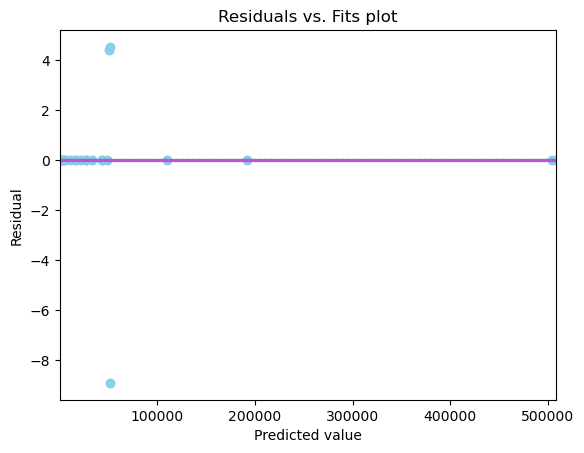

In [ ]:
# create residual plot
sns.residplot(x = preds_smogn,
              y = resid_smogn_train,
              lowess = True,
              line_kws = {'color' : 'mediumorchid'}, color='skyblue')\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual')
plt.show();

We see that assumptions of homoscedasticity are not satisfied since there are some residuals with high spread.

In [27]:
# calculate the base case r-squared for our model
base_1 = [y_train_smogn.mean()] * len(y_test_smogn)
r2_score(y_test_smogn, base_1)

-5.444492504058651e-05

We see that the model out-performed the baseline for our model.

Next we look at the RMSE for the train and test set:

In [32]:
# calculate rmse for test set
y_preds_test_smogn = lr.predict(X_test_smogn)
MSE = mean_squared_error(y_test_smogn, y_preds_test_smogn)
RMSE_test = math.sqrt(MSE)
print(f'RMSE for test: {RMSE_test}')

RMSE for test: 27889.054045762114


In [34]:
# calculate rmse for training set
y_preds_train_smogn = lr.predict(X_train_smogn)
MSE = mean_squared_error(y_train_smogn, y_preds_train_smogn)
RMSE_train = math.sqrt(MSE)
print(f'RMSE for train: {RMSE_train}')

RMSE for train: 2.1840341477328926


The RMSE for the test set is much higher than that for the test set, which means our model has overfitting. We already knew this.

We examine a scatterplot of the actual versus predicted values for y in the test set:

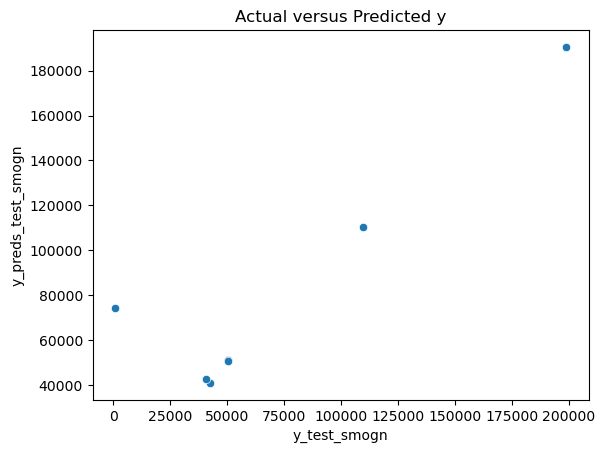

In [39]:
# create scatterplot of y_test_smogn versus y_preds_test_smogn
sns.scatterplot(x=y_test_smogn, y=y_preds_test_smogn)
# add title
plt.title('Actual versus Predicted y')
# add axes labels
plt.xlabel('y_test_smogn')
plt.ylabel('y_preds_test_smogn')
plt.show();

We have shown that the model we have after using SMOGN on the data is far better than a linear model on the original data. Although we still cannot call it a good model (because it is based off of a small sample size), **we recognize SMOGN as a valuable pre-processing tool for cases in uneven domains.**

#### Results
We look at some model coefficients and interpret some of its findings.

In [50]:
# create a dataframe of model coefficients
weights_df = pd.DataFrame(lr.coef_, 
                          index=X_smogn.columns)
weights_df.columns = ['weights']
weights_df.sort_values('weights', ascending=False, inplace=True)
weights_df.loc[weights_df.index.str.contains('software')]

,weights
software_valve anti-cheat,170969.979842
software,1994.723422
software_defense matrix,0.000000
software_fairfight,0.000000
bestsoftwarelints,-2628.309037
software_punkbuster,-14887.969342
software_easy anti-cheat,-44850.924514
software_none,-47928.574759
software_equ8,-52849.161751
software_ricochet,-62659.613215


We see from the coefficients for software that valve anti-cheat has a high coefficient and therefore is indicative of high incidence of cheating. On the otherhand, vanguard has a very negative coefficient and therefore is indicative of low incidence of cheating.

Interstingly, having no anti-cheat software (software_none) had a negative coefficient - it could be that companies do not include anti-cheat software in a game only in cases when it truly does not need one. 

We also notice that punkbuster and easy anti-cheat, which are both very polular, have negative coefficients.

In [51]:
weights_df.loc[weights_df.index.str.contains('pub_dev_same')]

,weights
pub_dev_same_1,-28135.590796


We see from the coefficients that if the publisher and developer are the same, it is indicative of a low incidence of cheating.

In [52]:
weights_df.head(10)

,weights
counterstrike,203634.280508
software_valve anti-cheat,170969.979842
bad,93101.968831
riot,85380.445502
player,81413.412888
source,64422.401748
condition,49735.948657
valve,48233.336361
tactical,47747.921666
scavs,46222.382933


We see that the word "counterstrike" and software valve anti-cheat have the highest coefficients (valve anti-cheat is used in counterstrike, which had the highest post count). We see some other words which are indicative of high incidences of cheating which are interesting.